In [1]:
import arviz as az
import pandas as pd
from pathlib import Path
from tbh.paths import REPO_ROOT_PATH, OUTPUT_PARENT_FOLDER

from matplotlib import pyplot as plt 
plt.style.use("ggplot")


import tbh.plotting as pl

## Load outputs

In [2]:
# from ipyfilechooser import FileChooser

# fc = FileChooser('/Users/rrag0004/Documents/Code/tb_hierarchical/remote_cluster/outputs/')
# fc.title = '<b>Select a folder</b>'
# fc.show_only_dirs = True  # only allow directory selection
# display(fc)

In [3]:
# analysis_path = Path(fc.selected_path)

In [4]:
# analysis_path = REPO_ROOT_PATH / "notebooks" / "test_outputs" / "test_full_analysis_scenarios_dfs"
analysis_path = OUTPUT_PARENT_FOLDER / "48092744_age_spec_target" / "task_1"
# analysis_path = REPO_ROOT_PATH / "notebooks" / "test_outputs" / "test_loading"

In [5]:
(analysis_path / "figures").mkdir(exist_ok=True)

In [6]:
intervention_scenarios = ["scenario_1", "scenario_2", "scenario_3"]
all_scenarios = ['baseline'] + intervention_scenarios
unc_dfs = {
    sc: pd.read_parquet(analysis_path / f"uncertainty_df_{sc}.parquet") for sc in all_scenarios
}
diff_outputs_dfs = {
    sc: pd.read_parquet(analysis_path / f"diff_quantiles_df_ref_baseline_{sc}.parquet") for sc in intervention_scenarios
}

## Plot model fits to calibration targets

In [7]:
import yaml

with open(analysis_path / "details.yaml" , "r") as f:
    docs = list(yaml.safe_load_all(f))

model_config = docs[1]
analysis_config = docs[2]

In [8]:
from tbh import runner_tools as rt
from tbh.model import get_tb_model
from estival.model import BayesianCompartmentalModel


params, priors, tv_params = rt.get_parameters_and_priors()

model = get_tb_model(model_config, tv_params)
bcm = BayesianCompartmentalModel(model, params, priors, rt.targets)

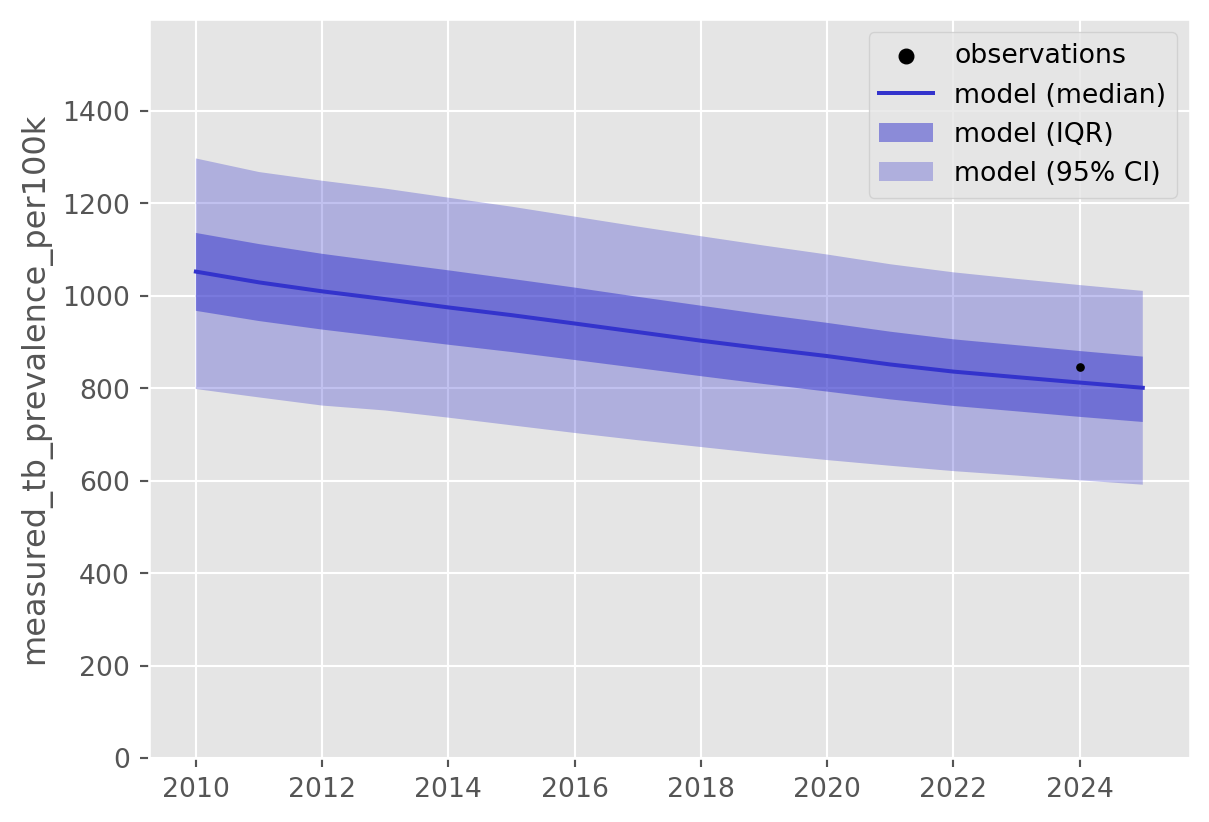

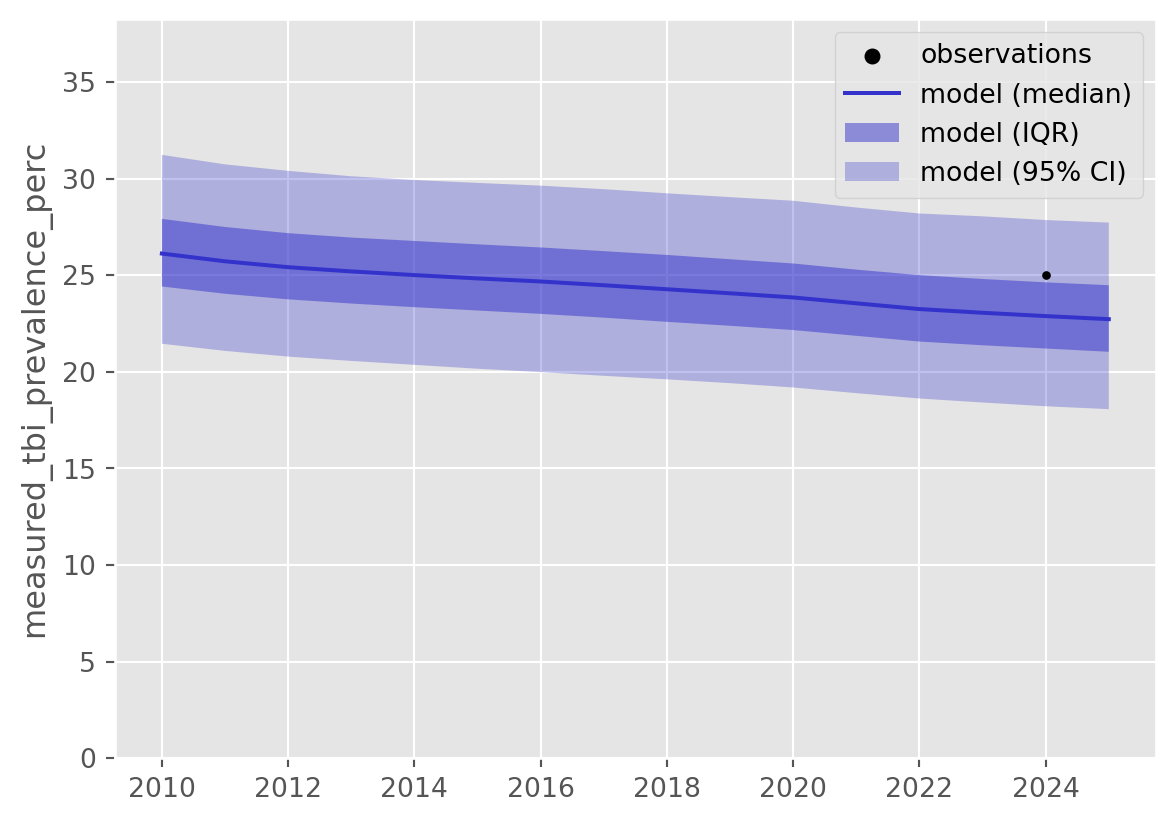

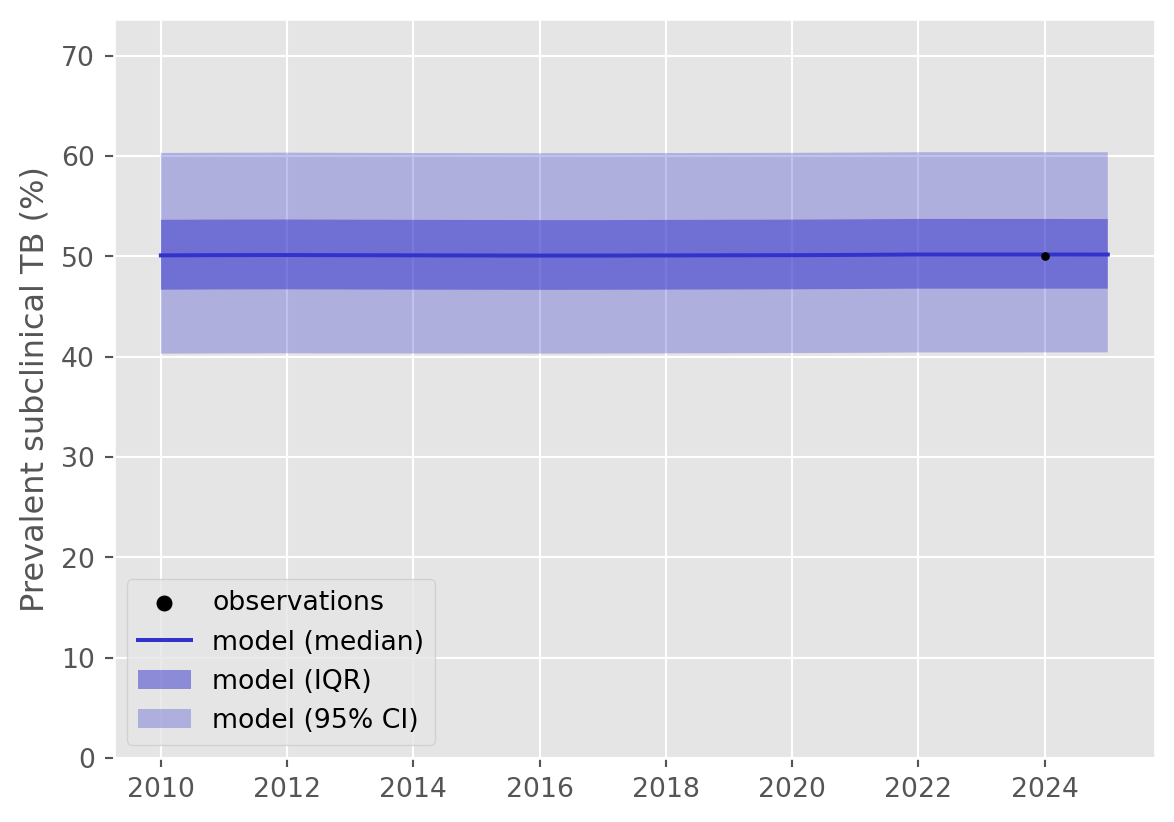

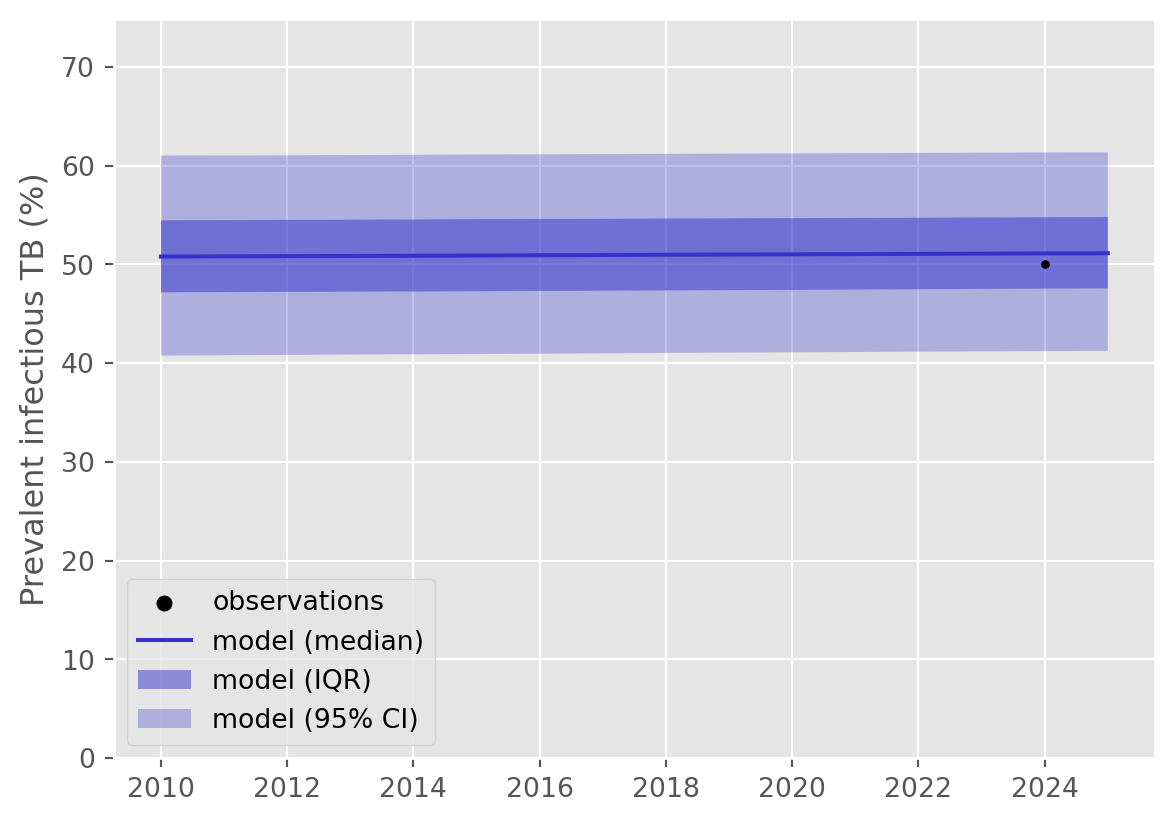

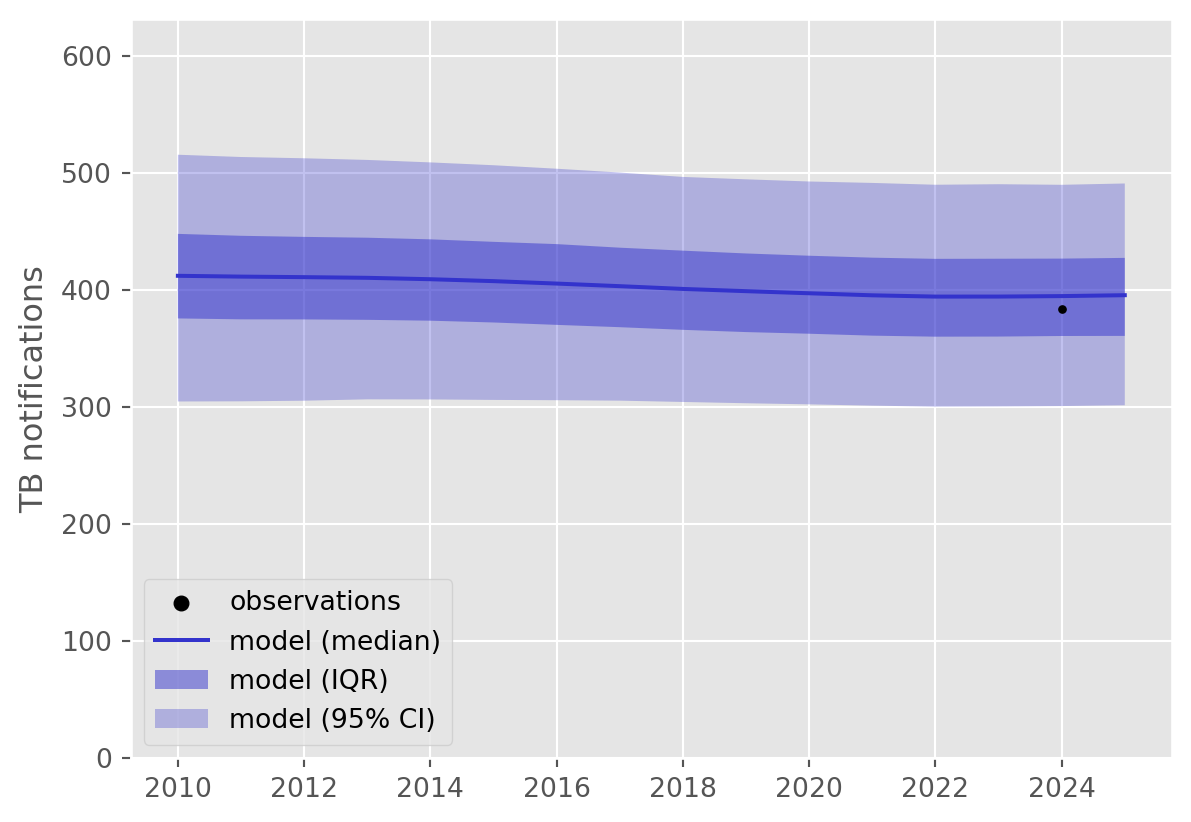

In [9]:
selected_outputs = bcm.targets.keys()
for output in selected_outputs:
    _, ax = plt.subplots()
    pl.plot_model_fit_with_uncertainty(ax, unc_dfs['baseline'], output, bcm, x_lim=(2010, 2025))
    
    plt.savefig(analysis_path / "figures" / f"fit_{output}.jpg", facecolor="white", bbox_inches='tight')

## Scenario comparison over time

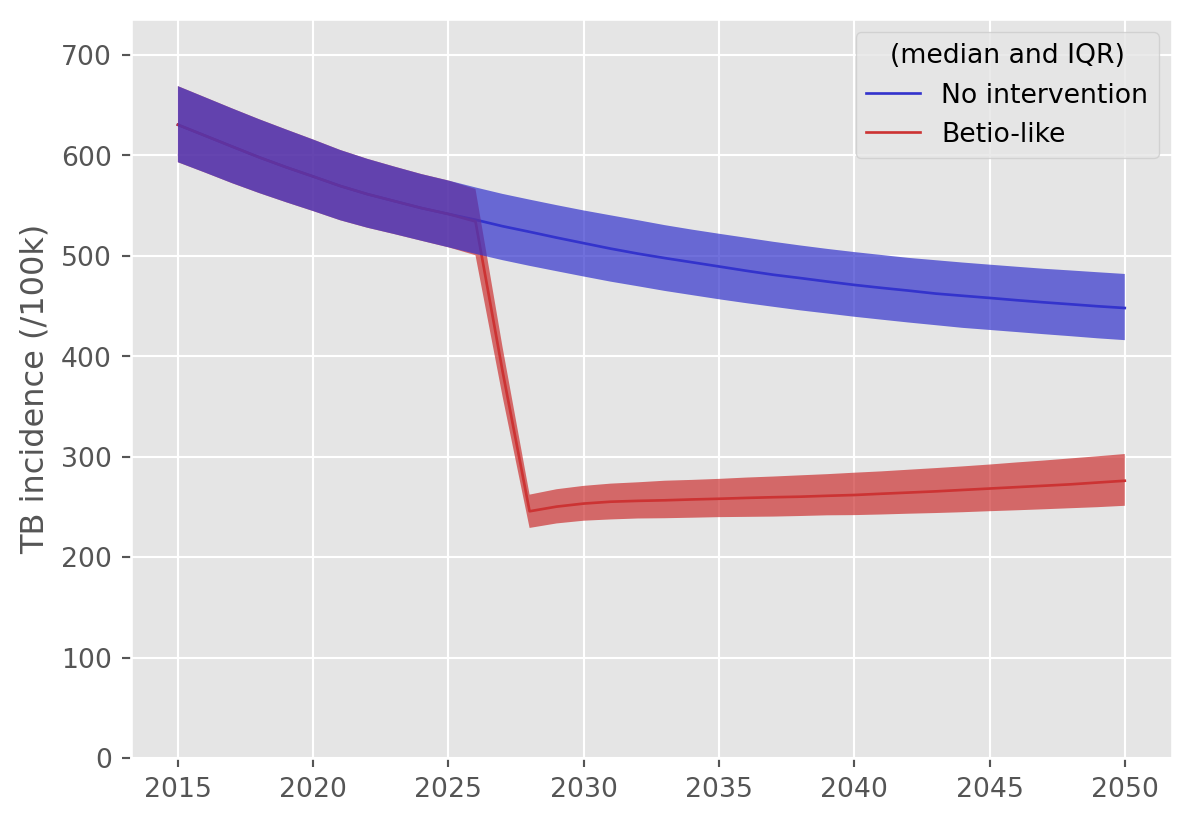

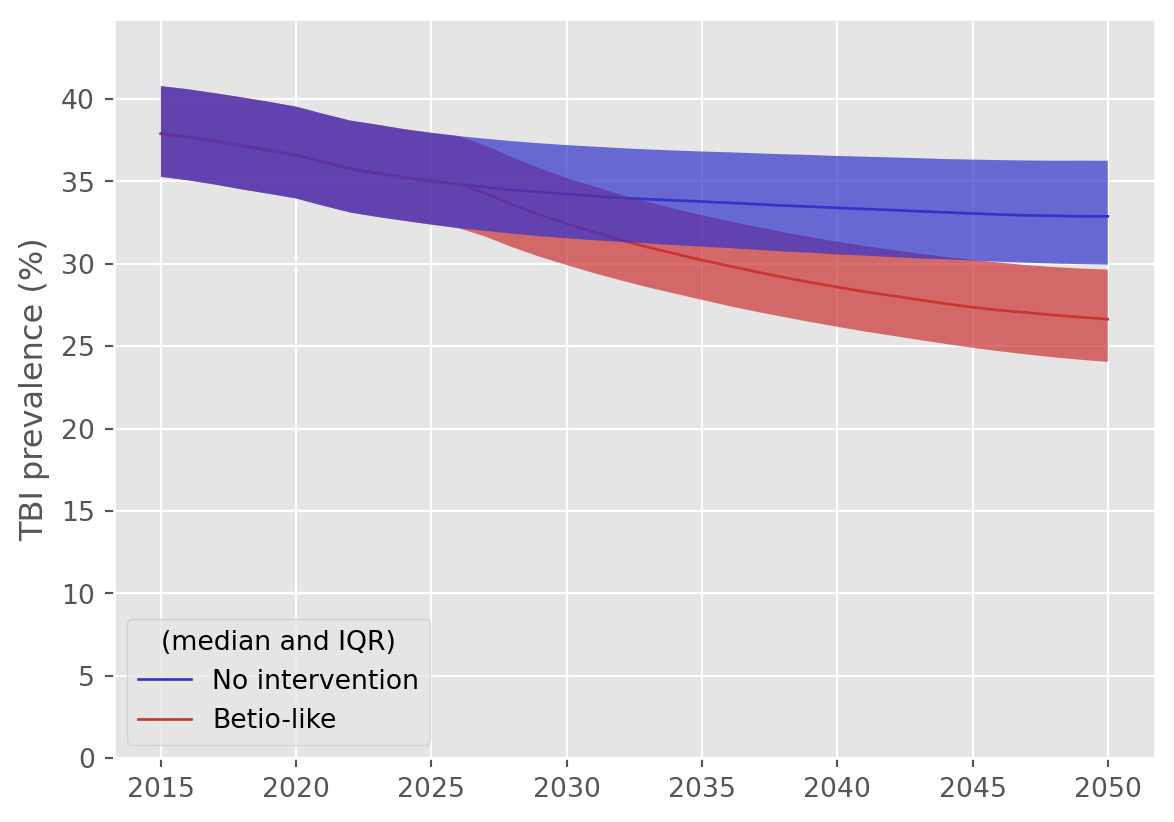

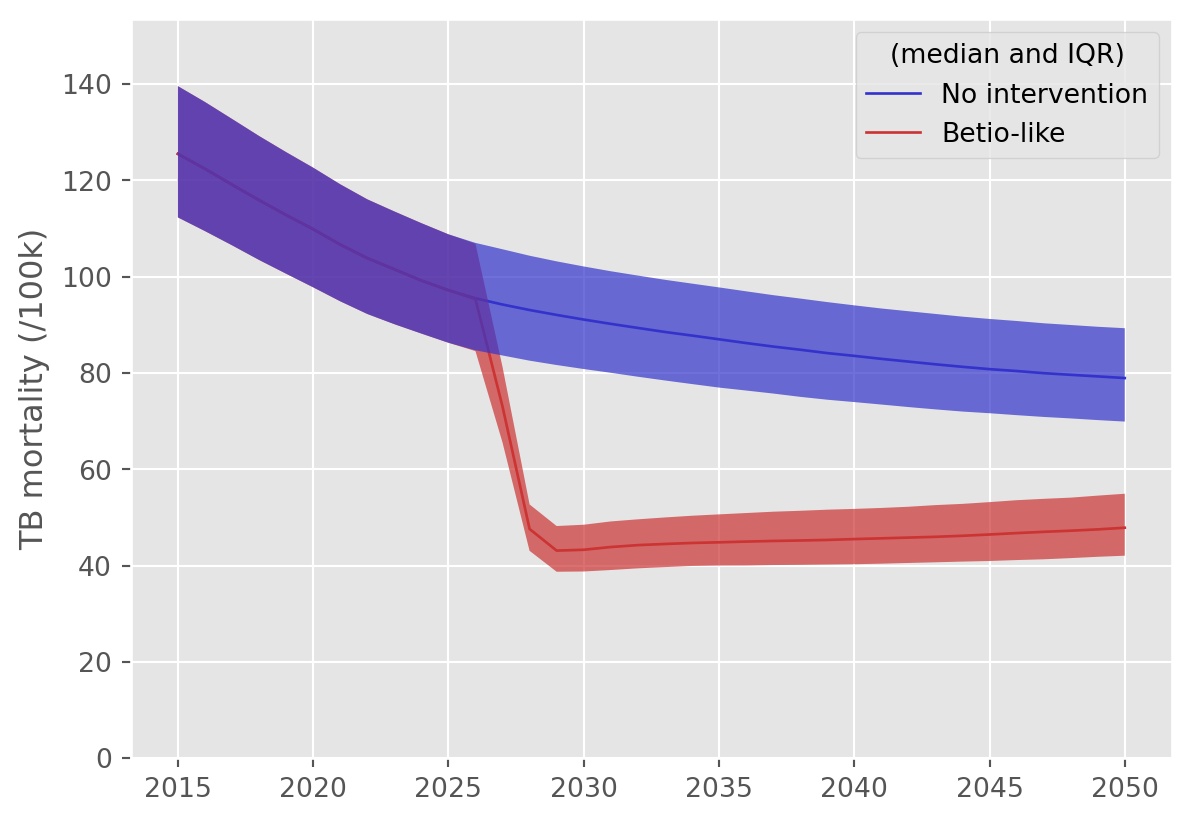

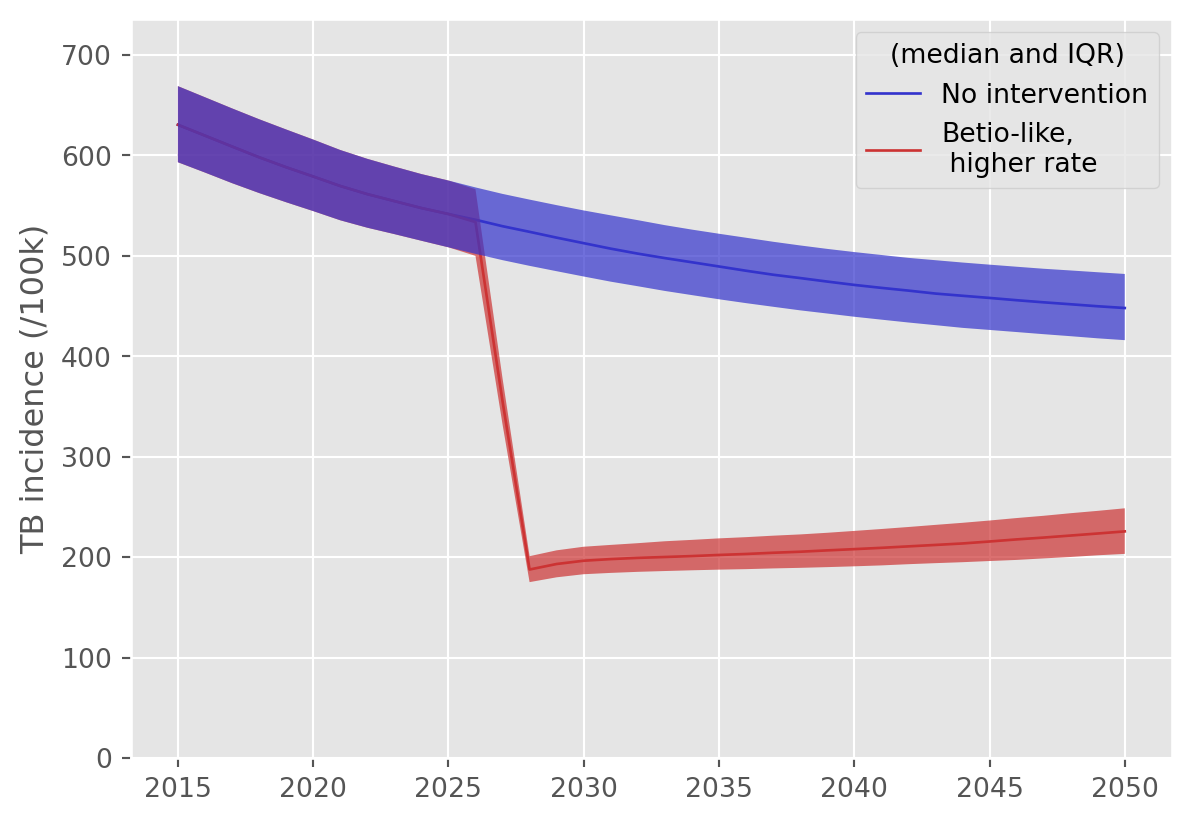

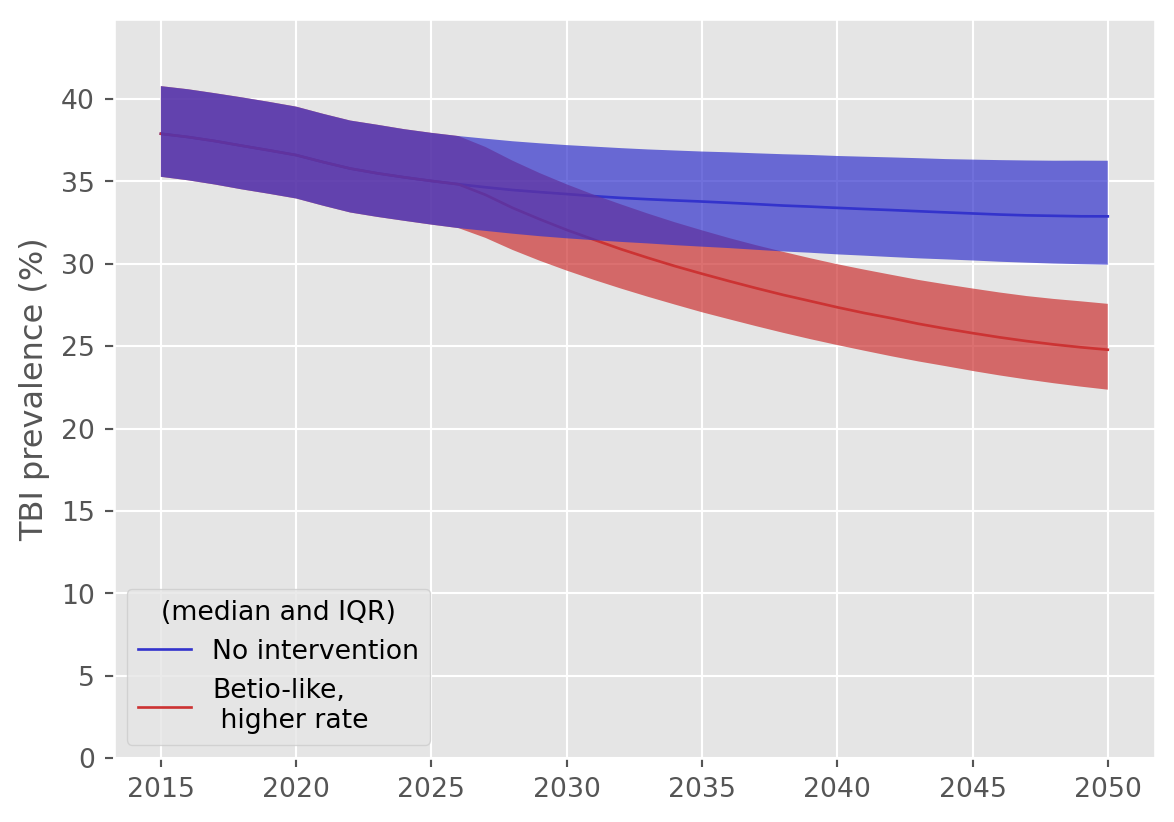

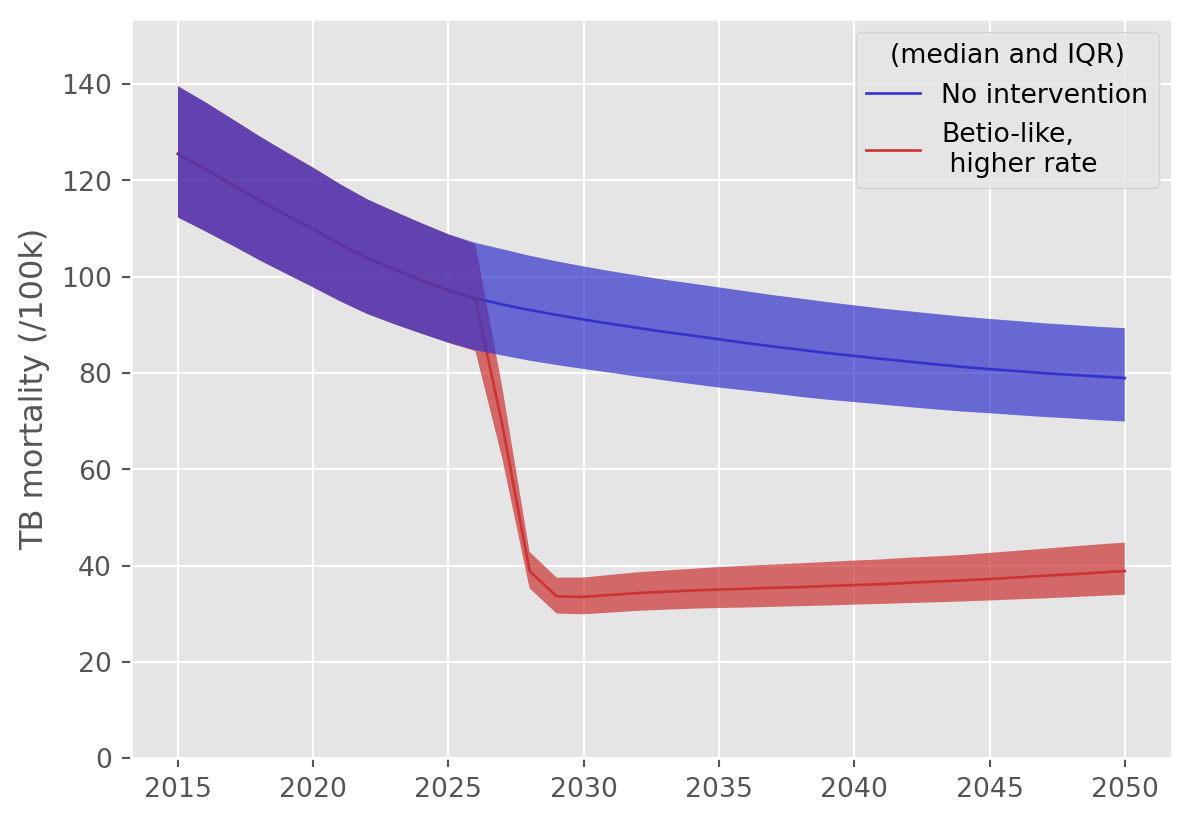

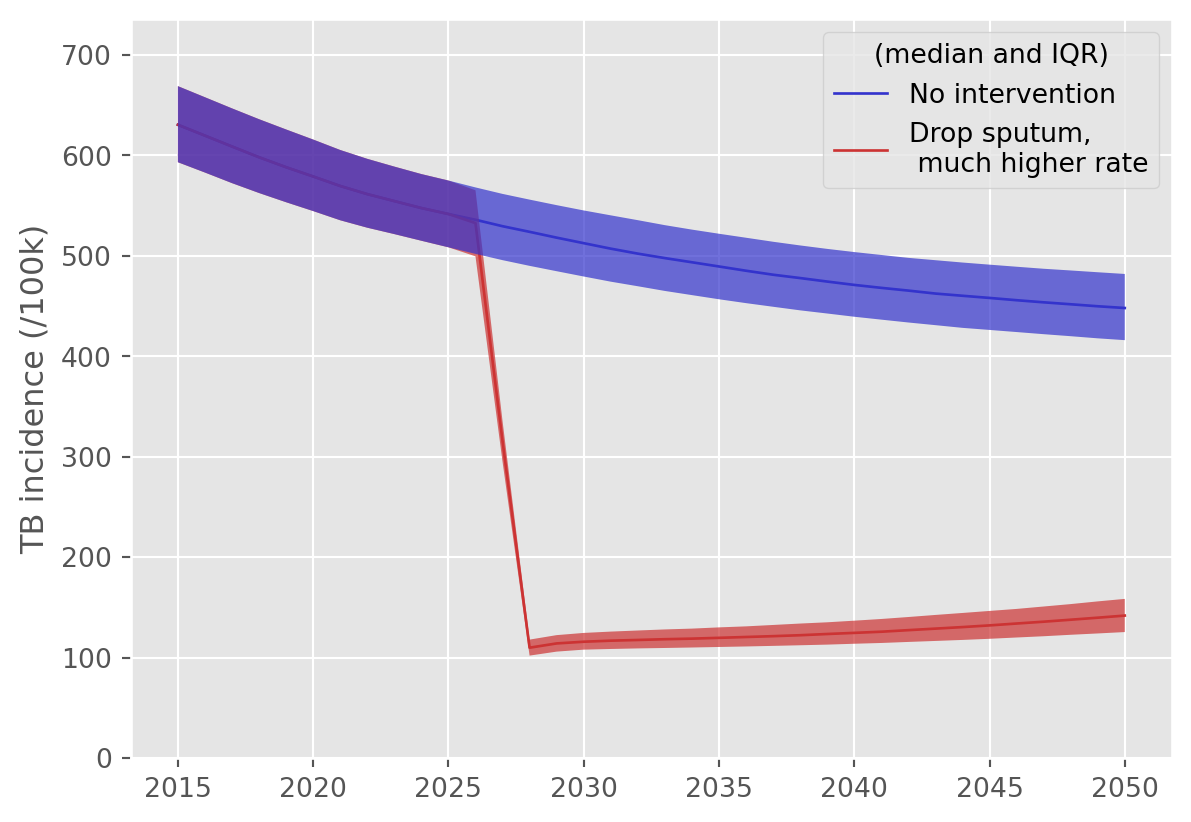

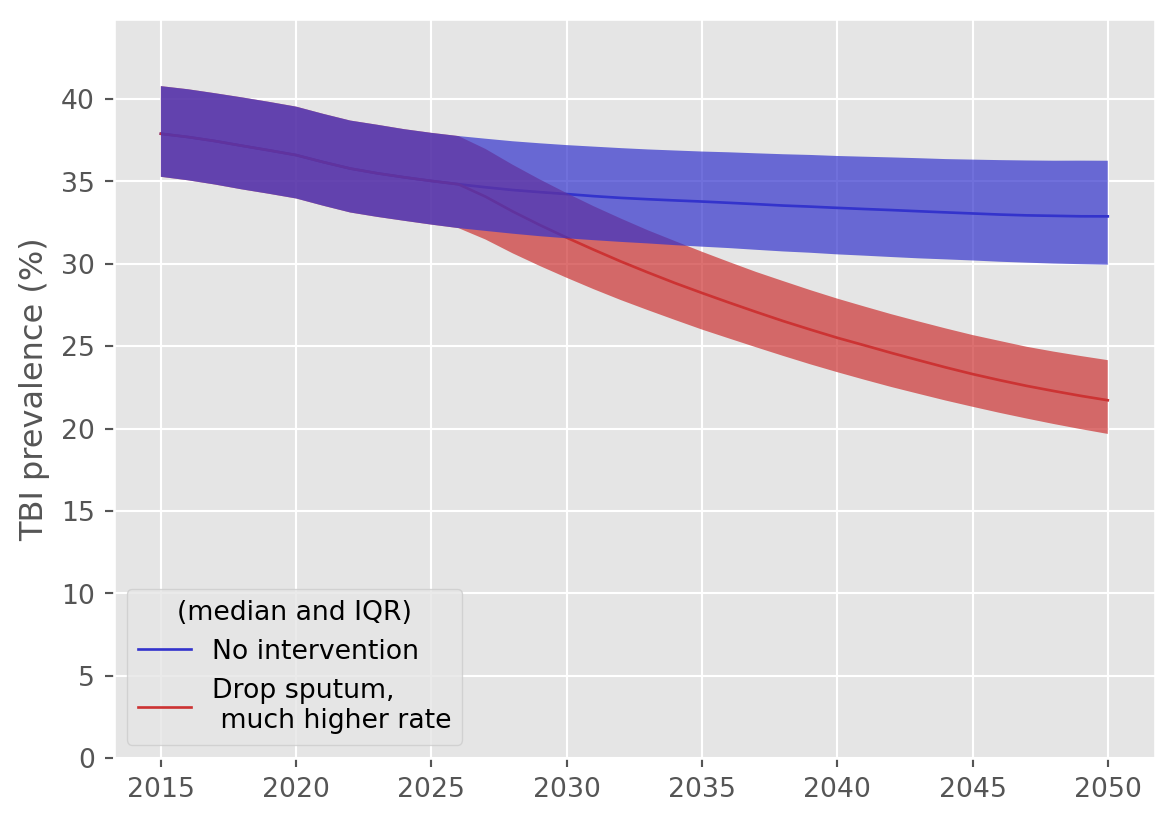

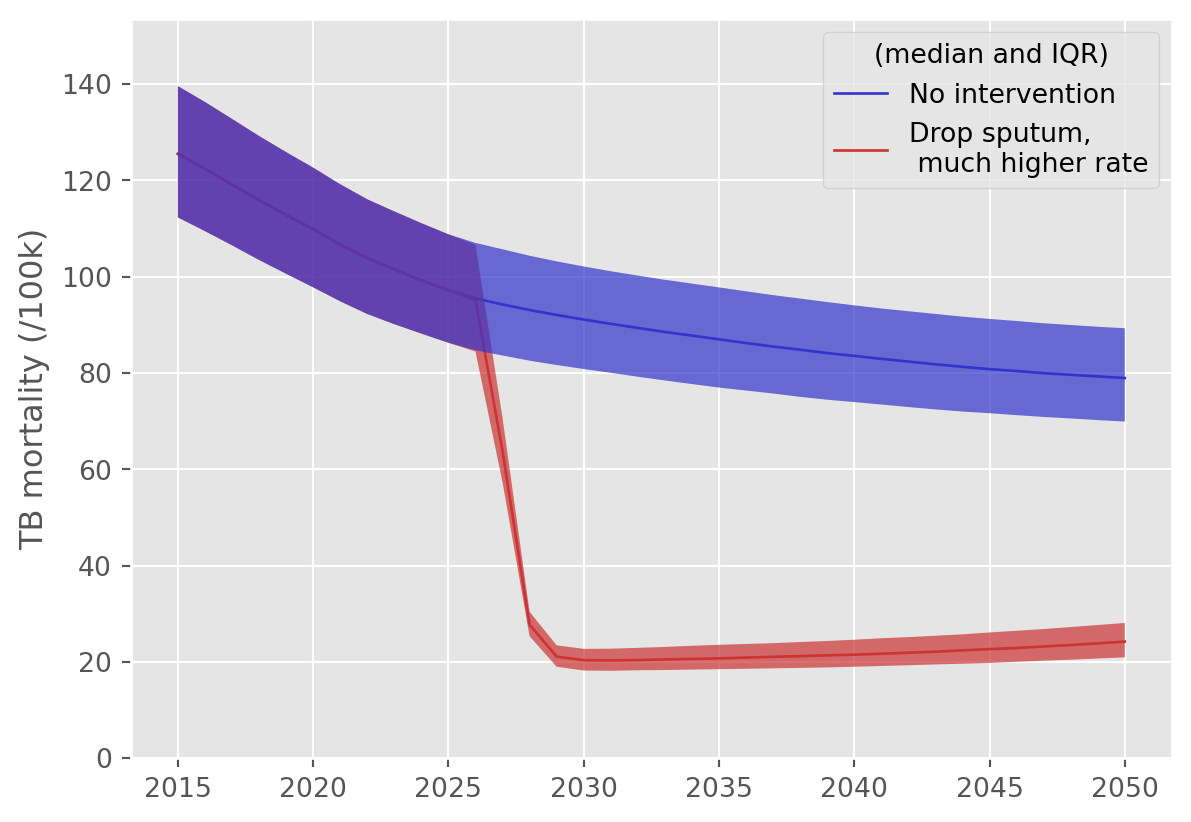

In [10]:
outputs_to_plot = ['tb_incidence_per100k', 'tbi_prevalence_perc', 'tb_mortality_per100k']

for sc in intervention_scenarios:
    for output in outputs_to_plot:
        fig, ax = plt.subplots(1, 1)
        pl.plot_two_scenarios(ax, unc_dfs, output, scenarios=['baseline', sc], xlim=(2015,2050), include_unc=True)

        plt.savefig(analysis_path / "figures" / f"{sc}_{output}.png")


## Cumulative outputs over 2020-2050

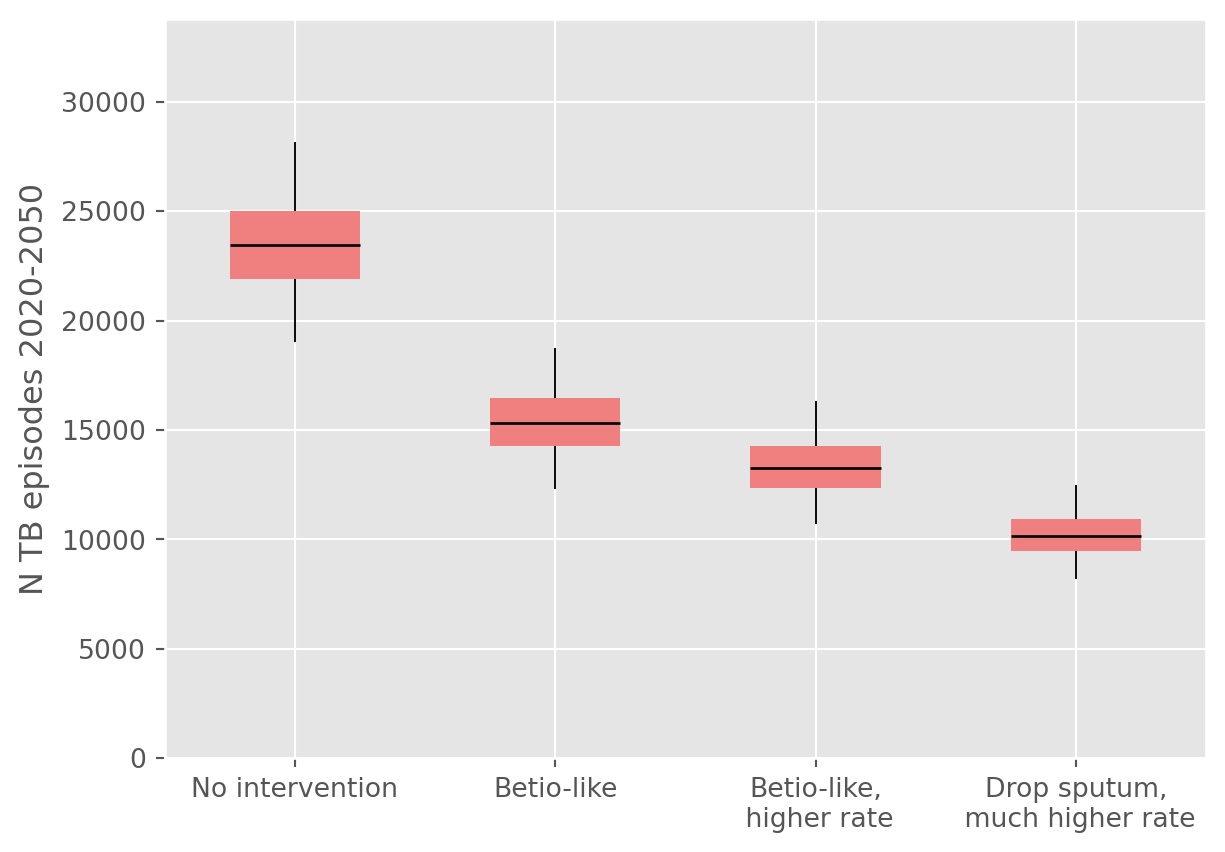

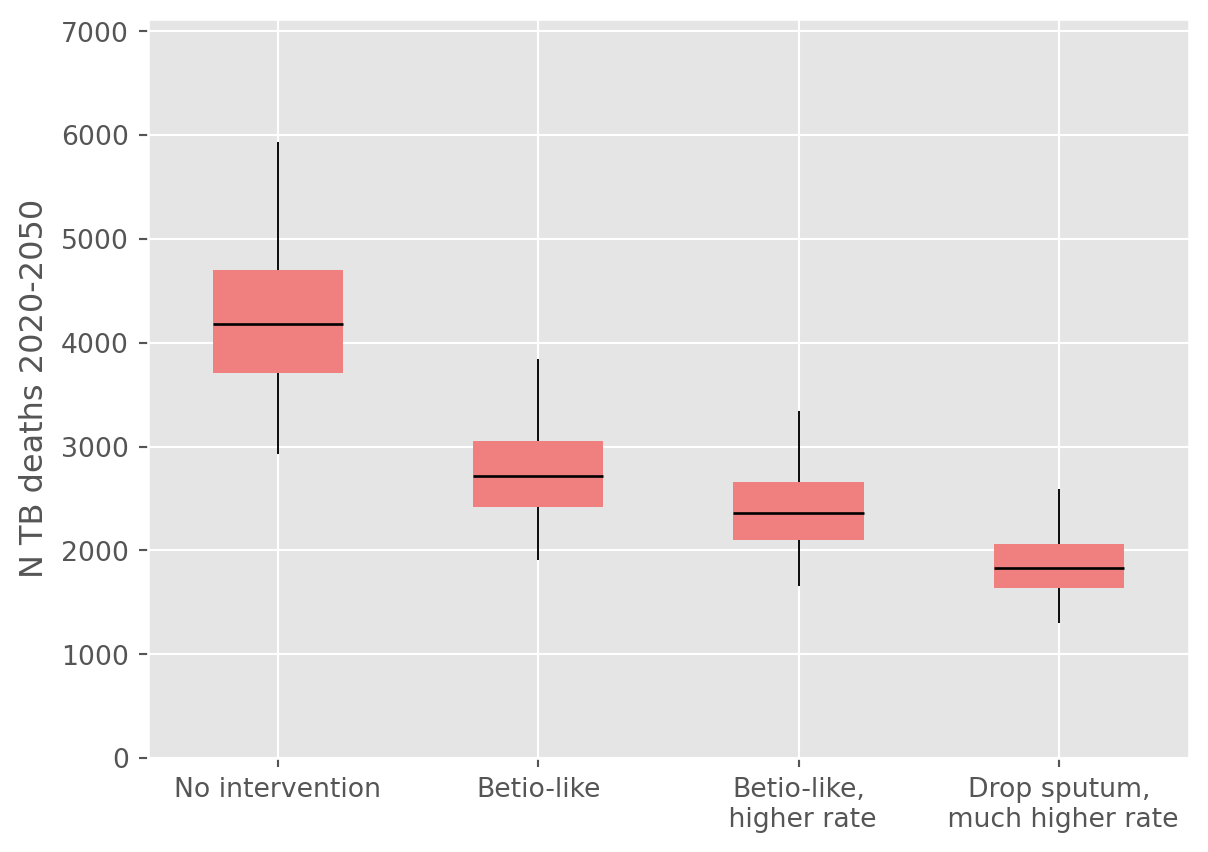

In [11]:
for output in ['cum_tb_incidence', 'cum_tb_mortality']:

    fig, ax = plt.subplots(1, 1)
    pl.plot_final_size_compare(ax,unc_dfs, output, all_scenarios)

    plt.savefig(analysis_path / "figures" / f"cumulative_{output}.png")


## Differential cumulative outputs over 2020-2050

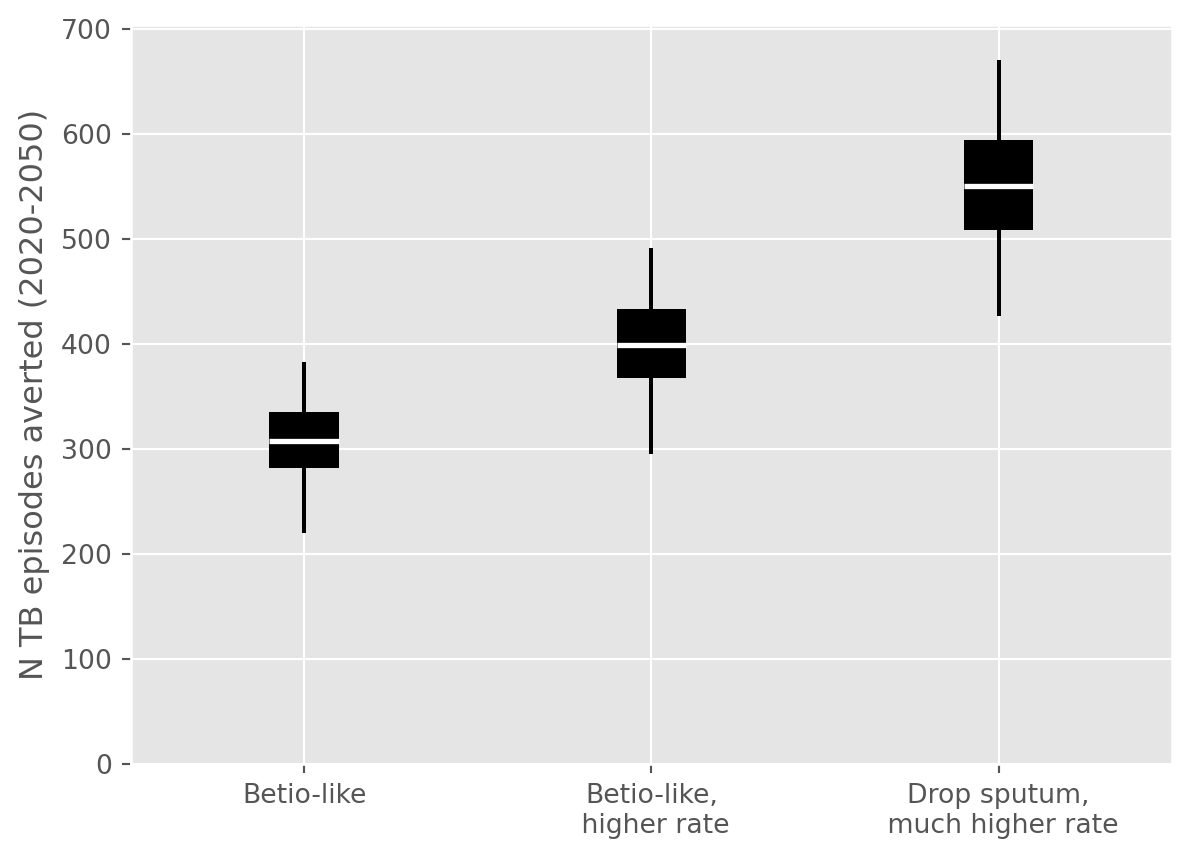

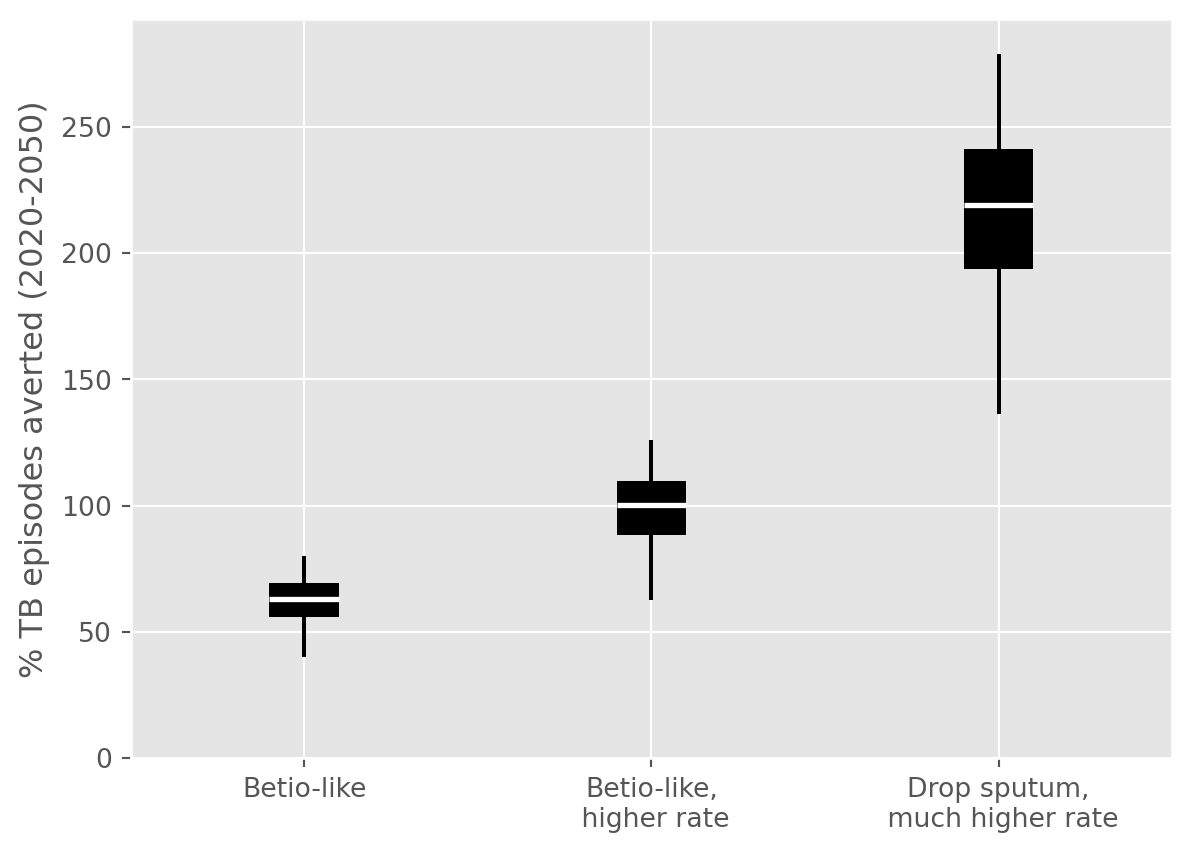

In [12]:
for output in ["TB_averted", "TB_averted_relative"]:

    fig, ax = plt.subplots(1, 1)
    pl.plot_diff_outputs(ax, diff_outputs_dfs, output, intervention_scenarios)

    plt.savefig(analysis_path / "figures" / f"diff_{output}.png")